In [ ]:
# EEG Classification BCI Task
# Computational Intelligence Course Final Project
# Armin Panjehpour - 98101288

In [ ]:
# Accessing google drive

from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/CI_Project_Dataset/'  


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [211]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
from scipy.io import loadmat
from scipy.fft import fft
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from scipy import signal
from sklearn.model_selection import KFold
import scipy 
import random

In [242]:
# Load Dataset
Data = mat = loadmat('/content/gdrive/MyDrive/Colab Notebooks/CI_Project_Dataset/CI_Project_data.mat')
print(Data.keys())
print('Dataset loaded!')

dict_keys(['__header__', '__version__', '__globals__', 'TestData', 'TrainData', 'TrainLabel'])
Dataset loaded!


In [267]:
# Training and Test Dataset

Train_Data = Data['TrainData']
Test_Data = Data['TestData']

# Training Dataset Labels
Labels = np.squeeze(Data['TrainLabel'])-1

# Dataset Size
print('Train_Data: ',Train_Data.shape)
print('Test_Data: ',Test_Data.shape)
print('Train_Label: ',Labels.shape)


print('Train\Test Data Created!')

Train_Data:  (30, 384, 120)
Test_Data:  (30, 384, 40)
Train_Label:  (120,)
Train\Test Data Created!


In [268]:
# Sampling Rate

Trial_Time = 1.5 # in seconds
Fs = Train_Data.shape[1]/Trial_Time

print('Sampling Rate is: ',Fs)

Sampling Rate is:  256.0


In [269]:
# different frequency bands in Hz
Delta_freq = [0.5, 3] 
Theta_freq = [4, 7]
Alpha_freq = [8, 12]
betha_freq = [12, 30]
Gamma_freq = [30, 100]

selected_frequency_band = betha_freq

In [270]:
# Train-Validation Split

# select 20% of train data as validation data
n_val_class1 = 10
n_val_class2 = 10
selected_class1 = np.random.choice(np.squeeze(np.where(Labels == 0)), size=n_val_class1, replace=False)
selected_class2 = np.random.choice(np.squeeze(np.where(Labels == 1)), size=n_val_class2, replace=False)
selected_valdata = np.concatenate((selected_class1, selected_class2))


Val_data = Train_Data[:,:,selected_valdata]
Val_Label = Labels[selected_valdata]
Train_Data = np.delete(Train_Data, selected_valdata, axis=2)
Train_Label = np.delete(Labels, selected_valdata)

print(Train_Data.shape, Val_data.shape, Train_Label.shape, Val_Label.shape)

(30, 384, 100) (30, 384, 20) (100,) (20,)


In [246]:
# normalize data
amp_norm = np.max(Train_Data, axis=(1,2))
std_norm = np.std(Train_Data, axis=(1,2))

for i in range(Train_Data.shape[0]):
  Train_Data[i,:,:] = (Train_Data[i,:,:] - amp_norm[i])/std_norm[i]
  Val_data[i,:,:] = (Val_data[i,:,:] - amp_norm[i])/std_norm[i]

print('data normalized!') 

data normalized!


In [271]:
# Export different bands of data 

# design a bandpass filter
order = 20
sos = signal.butter(order, selected_frequency_band, btype='bandpass', fs=Fs, output='sos')

# filter the data in time dimension
Train_Data_filtered = signal.sosfilt(sos, Train_Data, axis=1)
Test_Data_filtered = signal.sosfilt(sos, Test_Data, axis=1)
Val_Data_filtered = signal.sosfilt(sos, Val_data, axis=1)


# select unfiltered or filtered data
selected_Data = Train_Data
selected_val_Data = Val_data

print(selected_Data.shape)

(30, 384, 100)


In [ ]:
############################################ Calculate Different Features for Each Channel ############################################

In [142]:
def Var_Feature(data):
  # variance of each channel
  # dim1: channel number, dim2: time, dim3: trial number
  var = np.var(data, axis=1)
  return var

In [143]:
def amp_hist_Feature(data, n_bins, min_amp, max_amp):
  # amplitude histogram
  # dim1: channel number, dim2: time, dim3: trial number
  n_channels = data.shape[0]
  n_trials = data.shape[-1]
  
  hist_vals = np.zeros((n_channels,n_trials,n_bins))
  for i in range(n_channels):
    for j in range(n_trials):
      in_range = np.asarray(np.where((np.logical_and(1 <= data[i,:,j], data[i,:,j] <= 2)) == True))
      selected_chan_data = data[i, in_range, j]
      hist_vals[i,j,:] = np.histogram(selected_chan_data, n_bins)[0]
      
  
  return np.asarray(hist_vals)

In [144]:
def AR_Coeffs(data, order):
  # autoregressive model coefficients
  # dim1: channel number, dim2: time, dim3: trial number
  n_trials = data.shape[-1]
  n_samples = data.shape[1]
  n_channels = data.shape[0]
  Y = np.zeros((n_channels, n_samples-order, n_trials))
  Y = data[:, order:n_samples, :]

  X = np.zeros((n_trials, n_channels, n_samples-order, order+1))
  X[:,:,:,0] = 1

  Coeffs = np.zeros((n_trials, n_channels, order+1))

  for i in range(n_trials):
    for j in range(n_channels):
      for k in range(n_samples-order):
        for z in range(order):
          if(k-z >= 0):
            X[i,j,k,order-z-1] = data[j,k-z,i]
          else:
            X[i,j,k,order-z-1] = 0

      a = ((X[i,j,:,:].T @ X[i,j,:,:]) + np.asarray(0.00001*np.random.random((order+1, order+1))))
      Coeffs[i,j,:] = np.linalg.inv(a) @ (X[i,j,:,:].T) @ Y[j,:,i]

  return Coeffs

In [145]:
def FF_Feature(data):
  # form factor
  # dim1: channel number, dim2: time, dim3: trial number
  signal_std = np.std(data, axis=1)
  first_deriv_Std = np.std(np.diff(data, axis=1), axis=1)
  second_deriv_Std = np.std(np.diff(np.diff(data, axis=1), axis=1), axis=1)
  FF = (second_deriv_Std/first_deriv_Std)/(first_deriv_Std/signal_std)

  return FF

In [146]:
def cov_calculator(data1, data2):
  # covariancce calculator between two vector signals
  return np.sum(np.multiply(data1-np.mean(data1),data2-np.mean(data2)))/data1.shape[0]

In [376]:
def cov_Feature(data):
  # covariance between pairs of channels
  # dim1: channel number, dim2: time, dim3: trial number

  n_trials = data.shape[-1]
  n_samples = data.shape[1]
  n_channels = data.shape[0]

  cov_matrix = np.zeros((n_trials,n_channels,n_channels))

  for i in range(n_trials):
    for j in range(n_channels):
      for k in range(n_channels):
        selected_data_ch1 = data[j,:,i]
        selected_data_ch2 = data[k,:,i]
        cov_matrix[i,j,k] = cov_calculator(selected_data_ch1,selected_data_ch2)

  
  return cov_matrix

In [148]:
def kurtosis_Feature(data):
  # dim1: channel number, dim2: time, dim3: trial number

  n_trials = data.shape[-1]
  n_samples = data.shape[1]
  n_channels = data.shape[0]

  kurtosis = np.zeros((n_trials,n_channels))


  for i in range(n_trials):
    for j in range(n_channels):
      selected_data = data[j,:,i]
      kurtosis[i,j] = stats.kurtosis(selected_data)


  return kurtosis

In [149]:
def fft_calculator(data, Fs):
  # calculate single side band fft of a vector signal
  L = data.shape[0]
  fft_data = fft(data)
  P2 = np.abs(fft_data/L)
  P1 = P2[0:int(L/2)+1]
  P1[1:-1] = 2*P1[1:-1]

  f = Fs*np.arange(0,L/2+1)/L

  return f, P1

In [150]:
def max_freq_Feature(data, Fs):
  # find the frequency with the maximum amplitude for each channel
  # dim1: channel number, dim2: time, dim3: trial number
  
  n_trials = data.shape[-1]
  n_samples = data.shape[1]
  n_channels = data.shape[0]

  max_freq = np.zeros((n_trials,n_channels))

  for i in range(n_trials):
    for j in range(n_channels):
      selected_data = data[j,:,i]
      f, fft_selected_data = fft_calculator(selected_data, Fs)
      max_freq[i,j] = f[np.argmax(fft_selected_data)]

  return f, max_freq

In [151]:
def mean_freq_Feature(data, Fs):
  # find the normalized weighted mean of frequencies
  # dim1: channel number, dim2: time, dim3: trial number

  n_trials = data.shape[-1]
  n_samples = data.shape[1]
  n_channels = data.shape[0]

  mean_freq = np.zeros((n_trials,n_channels))

  for i in range(n_trials):
    for j in range(n_channels):
      selected_data = data[j,:,i]
      f, fft_selected_data = fft_calculator(selected_data, Fs)

      mean_freq[i,j] = np.sum(np.multiply(f, fft_selected_data))/np.sum(fft_selected_data)


  return f, mean_freq

In [152]:
# each band energy
def band_energy_Feature(raw_data, Fs):
  n_trials = raw_data.shape[-1]
  n_samples = raw_data.shape[1]
  n_channels = raw_data.shape[0]
  n_bands = 5

  band_energy = np.zeros((n_trials,n_channels,n_bands))
  freqs = np.array([[0.5, 3], [4, 7], [8, 12], [12, 30], [30, 100]])


  # energy of all bands

  denum = np.zeros((n_trials,n_channels))

  for i in range(n_trials):
    for j in range(n_channels):
      # sum over all energy bands
      for k in range(n_bands):
        # design a bandpass filter
        selected_frequency_band = freqs[k,:]
        order = 20
        sos = signal.butter(order, selected_frequency_band, 'bandpass', fs=Fs, output='sos')

        # filter the data in time dimension
        Data_filtered = signal.sosfilt(sos, raw_data[j,:,i])

        f, fft_selected_data = fft_calculator(Data_filtered, Fs)

        denum[i,j] += np.sum(np.power(fft_selected_data, 2))

    

  for i in range(n_trials):
    for j in range(n_channels):
      selected_data = raw_data[j,:,i]
      for kk in range(n_bands):
        # design a bandpass filter
        selected_frequency_band = freqs[kk,:]
        order = 20
        sos = signal.butter(order, selected_frequency_band, 'bandpass', fs=Fs, output='sos')

        # filter the data in time dimension
        Data_filtered = signal.sosfilt(sos, selected_data)

        f, fft_selected_data = fft_calculator(Data_filtered, Fs)

        # energy of the selected frequency band
        num = np.sum(np.power(fft_selected_data, 2))

        print(i,j,k)
        band_energy[i,j,kk] = num/denum[i,j]


  return band_energy

In [153]:
# each band energy
def band_energy_Feature1(x, fs):

  freqs = np.array([[0.5, 3], [4, 7], [8, 12], [12, 30], [30, 100]])

  n_trials = x.shape[-1]
  n_samples = x.shape[1]
  n_channels = x.shape[0]
  n_bands = 5
  psd = np.zeros((n_trials,n_channels,n_bands))

  for i in range(n_trials):
    for j in range(n_channels):
      selected_data = x[j,:,i]
      for k in range(n_bands):
        fmin = freqs[k,0]
        fmax = freqs[k,1]
        f, Pxx = scipy.signal.periodogram(selected_data, fs=fs)
        ind_min = scipy.argmax(f > fmin) - 1
        ind_max = scipy.argmax(f > fmax) - 1
        psd[i,j,k] = scipy.trapz(Pxx[ind_min: ind_max], f[ind_min: ind_max])
        
  return psd

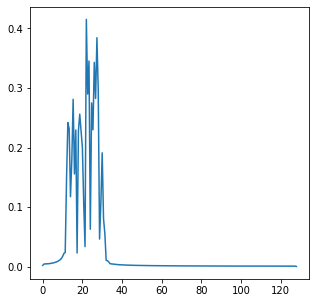

In [156]:
############################################ Averaged FFT over all trials and channels ############################################
f, fffft = fft_calculator(Train_Data_filtered[10,:,1], Fs)


fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(f, fffft)

In [155]:
############################################ Apply the Feature Functions on Training Data ############################################

In [272]:
# get trial numbers of two classes
class1_trialnum = np.squeeze(np.asarray(np.where(np.squeeze(Train_Label) == 0)))
class2_trialnum = np.squeeze(np.asarray(np.where(np.squeeze(Train_Label) == 1)))

class1_trialnum_val = np.squeeze(np.asarray(np.where(np.squeeze(Val_Label) == 0)))
class2_trialnum_val = np.squeeze(np.asarray(np.where(np.squeeze(Val_Label) == 1)))

print(class1_trialnum.shape, class2_trialnum.shape, class1_trialnum_val.shape, class2_trialnum_val.shape)

(50,) (50,) (10,) (10,)


In [421]:
# merged features
merged = []
merged_val = []

In [422]:
# calculate variance of each trail and channel - one value for each channel and trial for train data
var_feature = Var_Feature(selected_Data)

n_class = 2
var_feature_classes = np.zeros((n_class,int(var_feature.shape[1]/n_class),var_feature.shape[0]))

var_feature_classes[0,:,:] = var_feature.T[class2_trialnum,:]
var_feature_classes[1,:,:] = var_feature.T[class2_trialnum,:]
merged.append(var_feature_classes)

print(var_feature_classes.shape)

# for validation data
var_feature_val = Var_Feature(selected_val_Data)

n_class = 2
var_feature_classes_val = np.zeros((n_class,int(var_feature_val.shape[1]/n_class),var_feature_val.shape[0]))

var_feature_classes_val[0,:,:] = var_feature_val.T[class1_trialnum_val,:]
var_feature_classes_val[1,:,:] = var_feature_val.T[class2_trialnum_val,:]
merged_val.append(var_feature_classes_val)


print(var_feature_classes_val.shape)

(2, 50, 30)
(2, 10, 30)


In [423]:
# calculate amplitude histogram - nbin values for each channel for training data
n_bins = 5
min_amp = -10
max_amp = 10
hist_feature = amp_hist_Feature(selected_Data, n_bins, min_amp, max_amp)

n_class = 2
hist_feature_classes = np.zeros((n_class,hist_feature.shape[0],int(hist_feature.shape[1]/n_class),hist_feature.shape[-1]))

hist_feature_classes[0,:,:,:] = hist_feature[:,class1_trialnum,:]
hist_feature_classes[1,:,:,:] = hist_feature[:,class2_trialnum,:]

for i in range (hist_feature.shape[-1]):
  merged.append(np.moveaxis(hist_feature_classes[:,:,:,i], 1, 2))

print(hist_feature_classes.shape)

# for validation data
n_bins = 5
min_amp = -10
max_amp = 10
hist_feature_val = amp_hist_Feature(selected_val_Data, n_bins, min_amp, max_amp)

n_class = 2
hist_feature_classes_val = np.zeros((n_class,hist_feature_val.shape[0],int(hist_feature_val.shape[1]/n_class),hist_feature_val.shape[-1]))

hist_feature_classes_val[0,:,:,:] = hist_feature_val[:,class1_trialnum_val,:]
hist_feature_classes_val[0,:,:,:] = hist_feature_val[:,class2_trialnum_val,:]

for i in range (hist_feature_val.shape[-1]):
  merged_val.append(np.moveaxis(hist_feature_classes_val[:,:,:,i], 1, 2))



print(hist_feature_classes_val.shape)

(2, 30, 50, 5)
(2, 30, 10, 5)


In [424]:
# calculate AR coefficients - order values for each trail and channel
order = 5
ar_feature = AR_Coeffs(selected_Data, order)

n_class = 2
ar_feature_classes = np.zeros((n_class,int(ar_feature.shape[0]/n_class),ar_feature.shape[1],ar_feature.shape[-1]))

ar_feature_classes[0,:,:,:] = ar_feature[class1_trialnum,:,:]
ar_feature_classes[1,:,:,:] = ar_feature[class2_trialnum,:,:]

for i in range (ar_feature.shape[-1]):
  merged.append(ar_feature_classes[:,:,:,i])

print(ar_feature_classes.shape)


# for validation data
order = 5
ar_feature_val = AR_Coeffs(selected_val_Data, order)

n_class = 2
ar_feature_classes_val = np.zeros((n_class,int(ar_feature_val.shape[0]/n_class),ar_feature_val.shape[1],ar_feature_val.shape[-1]))

ar_feature_classes_val[0,:,:,:] = ar_feature_val[class1_trialnum_val,:,:]
ar_feature_classes_val[1,:,:,:] = ar_feature_val[class2_trialnum_val,:,:]

for i in range (ar_feature_val.shape[-1]):
  merged_val.append(ar_feature_classes_val[:,:,:,i])

print(ar_feature_classes_val.shape)

(2, 50, 30, 6)
(2, 10, 30, 6)


In [425]:
# calculate Form Factor -  one value for each channel and trial for training data
FF_feature = FF_Feature(selected_Data)

n_class = 2
FF_feature_classes = np.zeros((n_class,int(FF_feature.shape[1]/n_class),FF_feature.shape[0]))

FF_feature_classes[0,:,:] = FF_feature.T[class1_trialnum,:]
FF_feature_classes[1,:,:] = FF_feature.T[class2_trialnum,:]
merged.append(FF_feature_classes)

print(FF_feature_classes.shape)

# for validation data
FF_feature_val = FF_Feature(selected_val_Data)

n_class = 2
FF_feature_classes_val = np.zeros((n_class,int(FF_feature_val.shape[1]/n_class),FF_feature_val.shape[0]))

FF_feature_classes_val[0,:,:] = FF_feature_val.T[class1_trialnum_val,:]
FF_feature_classes_val[1,:,:] = FF_feature_val.T[class2_trialnum_val,:]
merged_val.append(FF_feature_classes_val)

print(FF_feature_classes_val.shape)

(2, 50, 30)
(2, 10, 30)


In [426]:
# calculate cov_Feature -  one covariance matrix for each trial for training data
cov_feature = cov_Feature(selected_Data)

n_class = 2
cov_feature_classes = np.zeros((n_class,int(cov_feature.shape[0]/n_class),cov_feature.shape[1],cov_feature.shape[1]))

cov_feature_classes[0,:,:] = cov_feature[class1_trialnum,:]
cov_feature_classes[1,:,:] = cov_feature[class2_trialnum,:]

for i in range (cov_feature.shape[1]):
  merged.append(cov_feature_classes[:,:,:,i])


print(cov_feature_classes.shape)

# for validation data
cov_feature_val = cov_Feature(selected_val_Data)

n_class = 2
cov_feature_classes_val = np.zeros((n_class,int(cov_feature_val.shape[0]/n_class),cov_feature_val.shape[1],cov_feature_val.shape[1]))

cov_feature_classes_val[0,:,:] = cov_feature_val[class1_trialnum_val,:]
cov_feature_classes_val[1,:,:] = cov_feature_val[class2_trialnum_val,:]

for i in range (cov_feature_val.shape[1]):
  merged_val.append(cov_feature_classes_val[:,:,:,i])

print(cov_feature_classes_val.shape)

(2, 50, 30, 30)
(2, 10, 30, 30)


In [427]:
# calculate kurtosis_Feature -  one number for each trial and channel
kurt_feature = kurtosis_Feature(selected_Data)


n_class = 2
kurt_feature_classes = np.zeros((n_class,int(kurt_feature.shape[0]/n_class),kurt_feature.shape[1]))

kurt_feature_classes[0,:,:] = kurt_feature[class1_trialnum,:]
kurt_feature_classes[1,:,:] = kurt_feature[class2_trialnum,:]
merged.append(kurt_feature_classes)

print(kurt_feature_classes.shape)

# for validation data
kurt_feature_val = kurtosis_Feature(selected_val_Data)

n_class = 2
kurt_feature_classes_val = np.zeros((n_class,int(kurt_feature_val.shape[0]/n_class),kurt_feature_val.shape[1]))

kurt_feature_classes_val[0,:,:] = kurt_feature_val[class1_trialnum_val,:]
kurt_feature_classes_val[1,:,:] = kurt_feature_val[class2_trialnum_val,:]
merged_val.append(kurt_feature_classes_val)

print(kurt_feature_classes_val.shape)

(2, 50, 30)
(2, 10, 30)


In [428]:
# calculate max_freq_Feature -  one max freq for each trail and channel for training data
f, max_freq_feature = max_freq_Feature(selected_Data, Fs)


n_class = 2
max_freq_feature_classes = np.zeros((n_class,int(max_freq_feature.shape[0]/n_class),max_freq_feature.shape[1]))

max_freq_feature_classes[0,:,:] = max_freq_feature[class1_trialnum,:]
max_freq_feature_classes[1,:,:] = max_freq_feature[class2_trialnum,:]
merged.append(max_freq_feature_classes)


print(max_freq_feature_classes.shape)

# for validation data
f, max_freq_feature_val = max_freq_Feature(selected_val_Data, Fs)


n_class = 2
max_freq_feature_classes_val = np.zeros((n_class,int(max_freq_feature_val.shape[0]/n_class),max_freq_feature_val.shape[1]))

max_freq_feature_classes_val[0,:,:] = max_freq_feature_val[class1_trialnum_val,:]
max_freq_feature_classes_val[1,:,:] = max_freq_feature_val[class2_trialnum_val,:]
merged_val.append(max_freq_feature_classes_val)

print(max_freq_feature_classes_val.shape)

(2, 50, 30)
(2, 10, 30)


In [429]:
# calculate mean_freq_Feature -  one mean freq for each trail and channel for training data
f, mean_freq_feature = mean_freq_Feature(selected_Data, Fs)

n_class = 2
mean_freq_feature_classes = np.zeros((n_class,int(max_freq_feature.shape[0]/n_class),max_freq_feature.shape[1]))

mean_freq_feature_classes[0,:,:] = mean_freq_feature[class1_trialnum,:]
mean_freq_feature_classes[1,:,:] = mean_freq_feature[class2_trialnum,:]
merged.append(mean_freq_feature_classes)


print(mean_freq_feature_classes.shape)

# for validation data
f, mean_freq_feature_val = mean_freq_Feature(selected_val_Data, Fs)

n_class = 2
mean_freq_feature_classes_val = np.zeros((n_class,int(mean_freq_feature_val.shape[0]/n_class),mean_freq_feature_val.shape[1]))

mean_freq_feature_classes_val[0,:,:] = mean_freq_feature_val[class1_trialnum_val,:]
mean_freq_feature_classes_val[1,:,:] = mean_freq_feature_val[class2_trialnum_val,:]
merged_val.append(mean_freq_feature_classes_val)

print(mean_freq_feature_classes_val.shape)

(2, 50, 30)
(2, 10, 30)


In [430]:
# selected band energy - one energy for each trail and channel for training data
band_energy_feature = band_energy_Feature1(selected_Data, Fs)

n_class = 2
band_energy_feature_classes = np.zeros((n_class,int(band_energy_feature.shape[0]/n_class),band_energy_feature.shape[1],band_energy_feature.shape[-1]))
band_energy_feature_classes[0,:,:,:] = band_energy_feature[class1_trialnum,:,:]
band_energy_feature_classes[1,:,:,:] = band_energy_feature[class2_trialnum,:,:]

for i in range (band_energy_feature.shape[-1]):
  merged.append(band_energy_feature_classes[:,:,:,i])


print(band_energy_feature_classes.shape)

# for validation data
band_energy_feature_val = band_energy_Feature1(selected_val_Data, Fs)

n_class = 2
band_energy_feature_classes_val = np.zeros((n_class,int(band_energy_feature_val.shape[0]/n_class),band_energy_feature_val.shape[1],band_energy_feature_val.shape[-1]))

band_energy_feature_classes_val[0,:,:,:] = band_energy_feature_val[class1_trialnum_val,:,:]
band_energy_feature_classes_val[1,:,:,:] = band_energy_feature_val[class2_trialnum_val,:,:]

for i in range (band_energy_feature_val.shape[-1]):
  merged_val.append(band_energy_feature_classes_val[:,:,:,i])


print(band_energy_feature_classes_val.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: scipy.argmax is deprecated and will be removed in SciPy 2.0.0, use numpy.argmax instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: scipy.argmax is deprecated and will be removed in SciPy 2.0.0, use numpy.argmax instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.trapz is deprecated and will be removed in SciPy 2.0.0, use numpy.trapz instead


(2, 50, 30, 5)
(2, 10, 30, 5)


In [414]:
def fisher_score_cal(bothclass_data,class1_data,class2_data):
  # calculate fisher score for each channel
  mean_bothclass = np.mean(bothclass_data)
  mean_class1 = np.mean(class1_data)
  mean_class2 = np.mean(class2_data)

  var_class1 = np.var(class1_data)
  var_class2 = np.var(class2_data)

  score = ((mean_bothclass-mean_class1)**2 + (mean_bothclass-mean_class2)**2)/(var_class1+var_class2)

  return score

In [431]:
merged[1][:,:,1].shape

(2, 50)

In [432]:
print(len(merged), len(merged_val))

51 51


In [442]:
n_all_features = 9
n_channel = 30
fisher_score = []
high_Fscored_features = []

thresh = 0.02

for i in range(n_all_features):
  for j in range(n_channel):
    selected_channel =  j
    selected_feature = merged[i][:,:,j]
    fisher_score.append(fisher_score_cal(selected_feature, selected_feature[0], selected_feature[1]))
    if(fisher_score[-1] > thresh):
      high_Fscored_features.append(np.asarray([i, j]))
  

print(len(fisher_score), len(high_Fscored_features))

findeds = np.where(np.asarray(fisher_score) > thresh)
print(findeds)

270 38
(array([ 30,  33,  47,  48,  51,  61,  63,  64,  71,  75,  78,  79,  80,
        87,  90,  99, 107, 109, 136, 142, 160, 167, 175, 176, 181, 184,
       188, 207, 209, 211, 214, 237, 239, 241, 244, 257, 267, 269]),)


In [443]:
n_class = 2
n_class_trial = 50
n_class_trial_val = 10

all_training_features = np.zeros((n_class, n_class_trial, len(high_Fscored_features)))
all_val_features = np.zeros((n_class, n_class_trial_val, len(high_Fscored_features)))

for i in range(len(high_Fscored_features)):
  all_training_features[:,:,i] = merged[high_Fscored_features[i][0]][:,:,high_Fscored_features[i][1]]
  all_val_features[:,:,i] = merged_val[high_Fscored_features[i][0]][:,:,high_Fscored_features[i][1]]


print(all_training_features.shape, all_val_features.shape)

(2, 50, 38) (2, 10, 38)


In [ ]:
# it seems that non of the features give us high fisher score just by them self

In [444]:
# for training data
# lets check some features together # 
group_features_class1 = all_training_features[0,:,:]
group_features_class2 = all_training_features[1,:,:]
group_features_both = np.concatenate((group_features_class1, group_features_class2), axis=0)


# normalize feature matrices 
group_features_both = stats.zscore(group_features_both, axis=1)
group_features_class1 = group_features_both[class1_trialnum,:]
group_features_class2 = group_features_both[class2_trialnum,:]

# shuffling
np.random.shuffle(group_features_both)


print(group_features_class1.shape, group_features_class2.shape, group_features_both.shape)

# for validation
group_features_class1_val = all_val_features[0,:,:]
group_features_class2_val = all_val_features[1,:,:]
group_features_both_val = np.concatenate((group_features_class1_val, group_features_class2_val), axis=0)

# normalize feature matrices 
group_features_both_val = stats.zscore(group_features_both_val, axis=1)
group_features_class1_val = group_features_both_val[class1_trialnum_val,:]
group_features_class2_val = group_features_both_val[class2_trialnum_val,:]

# shuffling
np.random.shuffle(group_features_both_val)


print(group_features_class1_val.shape, group_features_class2_val.shape, group_features_both_val.shape)

(50, 38) (50, 38) (100, 38)
(10, 38) (10, 38) (20, 38)


In [446]:
# score

scores = []

n_rep = 1000
n_selected_features = 30
all_selected_features = []

for j in range (n_rep):
  selected_features = random.sample(range(group_features_both_val.shape[-1]), 10)
  all_selected_features.append(selected_features)

  group_1 = group_features_class1[:,selected_features]
  group_2 = group_features_class2[:,selected_features]
  both_groups = group_features_both[:, selected_features]

  S1 = np.zeros((group_1.shape[1],group_1.shape[1]))
  S2 = np.zeros((group_2.shape[1],group_2.shape[1]))

  n_trials = 50
  n_class = 2
  for i in range(n_trials):
    S1 += (group_1[i,:] - np.mean(group_1, axis=0)) @ (group_1[i,:] - np.mean(group_1, axis=0)).T
    S2 += (group_2[i,:] - np.mean(group_2, axis=0)) @ (group_2[i,:] - np.mean(group_2, axis=0)).T

  S1 /= n_trials
  S2 /= n_trials  

  Sw = S1+S2

  # between class matrix
  Sb = np.zeros((group_1.shape[1],group_1.shape[1]))

  mean_all = np.expand_dims(np.mean(both_groups, axis=0), axis=1)
  mean_class1 = np.expand_dims(np.mean(group_1, axis=0), axis=1)
  mean_class2 = np.expand_dims(np.mean(group_2, axis=0), axis=1)

  Sb = ((mean_class1-mean_all) @ (mean_class1-mean_all).T) + ((mean_class2-mean_all) @ (mean_class2-mean_all).T)


  # final score
  J = np.trace(Sb)/np.trace(Sw)
  print('final score is: ', J)
  scores.append(J)

print(np.max(scores), np.argmax(scores), scores[np.argmax(scores)])

target_feature = all_selected_features[np.argmax(scores)]


final score is:  0.001084630669889111
final score is:  0.0011361490034796958
final score is:  0.001174032991086809
final score is:  0.0015853282961045176
final score is:  0.001332786201899719
final score is:  0.001660993303208666
final score is:  0.0015046181868979495
final score is:  0.0016602302300374582
final score is:  0.0016659855840180221
final score is:  0.0011816582155863746
final score is:  0.001677236609783469
final score is:  0.001647204197945015
final score is:  0.0009941715336049919
final score is:  0.0008544946803504776
final score is:  0.0015266781853613051
final score is:  0.001475629620344207
final score is:  0.0013050124897204475
final score is:  0.0014078318363552938
final score is:  0.0014169979214193216
final score is:  0.0017320405179482063
final score is:  0.0008865732582977667
final score is:  0.0016496186246293765
final score is:  0.0009203548614415533
final score is:  0.001531028311239124
final score is:  0.0017218328516533296
final score is:  0.00213308046515

In [447]:
# change y to one hot labels
# we have 2 classes, so our MLP will have 2 output neurons which one neuron 
# will be one and the others zero
from tensorflow.keras.utils import to_categorical

y_tr_hot = to_categorical(Train_Label)
y_val_hot = to_categorical(Val_Label)

print(y_tr_hot.shape, y_val_hot.shape)

(100, 2) (20, 2)


In [448]:
# Define the K-fold Cross Validator
# Setting up the layers
from tensorflow.keras.layers import Input, Dense, Activation, Softmax
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

final_features = group_features_both[:,target_feature]


fold_no = 1
acc_per_fold = []
loss_per_fold = []
input_layer_size = group_features_both[:,target_feature].shape[1]
for train, test in kfold.split(final_features, y_tr_hot):
  # CREATE MLP MODEL
  # Setting up the layers



  model = keras.Sequential([
                        Input(shape = (input_layer_size,)), # input layer
                        Dense(units = 10), # hidden layer one
                        Activation(activation = tf.math.tanh),
                        Dense(units = 10), # hidden layer two
                        Activation(activation = tf.math.tanh),
                        Dense(units = 2), # output layer
                        Softmax(axis = 1)
  ])

  # Compling the model

  # make our model ready for training
  # 1. optimizer 2. loss function 3. metrics

  model.compile(
      optimizer = keras.optimizers.SGD(learning_rate=0.001),
      loss = keras.losses.CategoricalCrossentropy(),
      metrics = ['accuracy']
  )

  print(f'Training for fold {fold_no} ...')


  hist = model.fit(
      final_features[train],
      y_tr_hot[train],
      batch_size=5,
  )

  # Generate generalization metrics
  scores = model.evaluate(final_features[test], y_tr_hot[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Evaluations, test the model on test data using keras
  results = model.evaluate(group_features_both_val[:,target_feature], y_val_hot)

  print(results)

  # Increase fold number
  fold_no = fold_no + 1

Training for fold 1 ...
16/16 [==============================] - 0s 2ms/step - loss: 0.9667 - accuracy: 0.4125
Score for fold 1: loss of 0.7290371656417847; accuracy of 55.000001192092896%
1/1 [==============================] - 0s 21ms/step - loss: 0.7900 - accuracy: 0.5000
[0.7899616956710815, 0.5]
Training for fold 2 ...
16/16 [==============================] - 0s 3ms/step - loss: 0.7963 - accuracy: 0.5000
Score for fold 2: loss of 0.7949598431587219; accuracy of 60.00000238418579%
1/1 [==============================] - 0s 20ms/step - loss: 0.7611 - accuracy: 0.5500
[0.7610810995101929, 0.550000011920929]
Training for fold 3 ...
16/16 [==============================] - 0s 2ms/step - loss: 0.7223 - accuracy: 0.4750
Score for fold 3: loss of 0.6460062861442566; accuracy of 64.99999761581421%
1/1 [==============================] - 0s 24ms/step - loss: 0.6889 - accuracy: 0.5500
[0.6889074444770813, 0.550000011920929]
Training for fold 4 ...
16/16 [==============================] - 0s 2ms